In [2]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2
ERROR: No matching distribution found for cv2


In [1]:
import os
import warnings
from os.path import isfile, join
from typing import Dict, List, Tuple, Union

# import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from colour import Color
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms 
from tqdm.notebook import trange, tqdm
from model import UNet
from pathlib import Path
from IPython.display import clear_output


warnings.filterwarnings("ignore")

# Датасет для пар (картинка, маска) 

In [2]:
class Carvana(Dataset):
    def __init__(
        self,
        root: str,
        transform: transforms.Compose = None,
    ) -> None:
        """
        :param root: путь к папке с данными
        :param transform: transforms of the images and labels
        """
        self.root = os.path.expanduser(root)
        self.transform = transform
        (self.data_path, self.labels_path) = ([], [])

        def load_images(path: str) -> List[str]:
            """
            Возвращает список с путями до всех изображений

            :param path: путь к папке с данными
            :return: лист с путями до всех изображений
            """
            images_dir = [join(path, f) for f in os.listdir(path)
                          if isfile(join(path, f))]
            images_dir.sort()

            return images_dir

        self.data_path = load_images(self.root + "/train")
        self.labels_path = load_images(self.root + "/train_masks")

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        :param index: sample index
        :return: tuple (img, target) with the input data and its label
        """
        img = Image.open(self.data_path[index])
        target = Image.open(self.labels_path[index])

        if self.transform is not None:
            img = self.transform(img)
            target = self.transform(target)
            target = (target > 0).float()

        return (img, target)

    def __len__(self):
        return len(self.data_path)

    
def im_show(img_list: List[Tuple[str, str]]) -> None:
    """
    Plots images with correspinding segmentation mask
    
    :param img_list: list of paths to images
    """

    to_PIL = transforms.ToPILImage()
    if len(img_list) > 9:
        raise Exception("len(img_list) must be smaller than 10")
        
    fig, axes = plt.subplots(len(img_list), 2, figsize=(16, 16))
    fig.tight_layout()

    for (idx, sample) in enumerate(img_list):
        a = axes[idx][0].imshow(np.array(to_PIL(sample[0])))
        b = axes[idx][1].imshow(np.array(to_PIL(sample[1])))
        for ax in axes[idx]:
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()

Создание датасета из картинок в папках root +"train"\"train_masks" 

In [3]:
transform=transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()])

In [4]:
val_percent = 0.1 

In [20]:
dataset = Carvana(
    root=".",
    transform=transform
)

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=5,
    shuffle=True,
    pin_memory=True
#     ,num_workers=2 
#   add num_workers if there will be enough memory 
)

val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=5,
    shuffle=False,
    pin_memory=True
#     ,num_workers=2 
#   add num_workers if there will be enough memory 
)

In [21]:
dataset.__getitem__(1)[1].shape

torch.Size([1, 256, 256])

In [22]:
len(dataset)

138

Посмотреть примеры изображений в датасете 

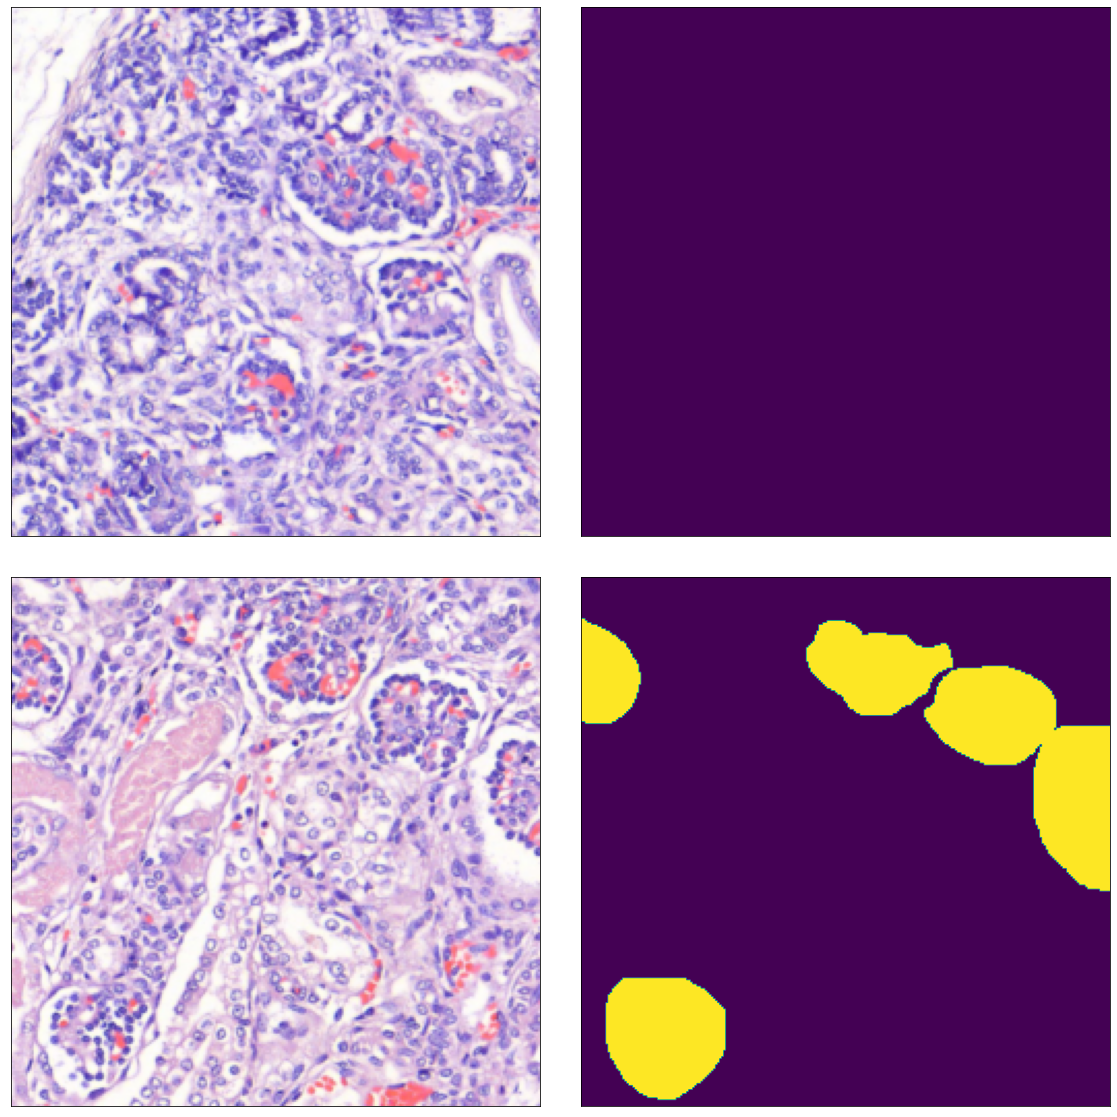

In [25]:
img_list = []
for i in range(2):
    img, label = dataset[np.random.randint(0, 10)]
    img_list.append((img, label))

im_show(img_list)

# Инициализация UNet 

In [26]:
net = UNet(n_channels=3, bilinear=True)

# Обучение 

In [27]:
def evaluate(model, val_loader, criterion, device = "cpu"): 
    model.eval() 
                
    total_loss = 0
    accuracy_arr = []
    with torch.no_grad(): 
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels).item() 
            accuracy = ((outputs > 0.5) == labels).float().mean().item()
            
            total_loss += loss
            accuracy_arr.append(accuracy)
    model.train()
    return total_loss, np.array(accuracy_arr).mean()

In [28]:
def plots_scores(val_losses, val_accs, train_losses,train_accs, epoch, num_epochs): 
    
    fig, ax = plt.subplots()
    fig.set_figwidth(20)    #  ширина и
    fig.set_figheight(8)

    plt.subplot(1,2,1)
    plt.plot(val_losses, label="Validation loss")
    plt.plot(train_losses, label="Train loss")
    plt.title(f"Episode {1+epoch}/{num_epochs}")
    plt.xlabel("Number of epoch", fontsize=14)
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(val_accs, label="Validation accuracy")
    plt.plot(train_accs, label="Train accuracy")
    plt.title(f"Episode {1+epoch}/{num_epochs}")
    plt.xlabel("Number of epoch", fontsize=14)
    plt.legend()

    plt.show()

In [29]:
def train(train_loader, 
          val_loader, 
          model, 
          criterion, 
          num_epochs, 
          device = "cpu", 
          dir_chechpoints = None,
          validation_step = 2):
    
    val_losses = []
    val_accs = []
    train_losses = [] 
    train_accs = [] 
    
    for epoch in range(0, num_epochs):
        
        total_loss = 0
        total_accuracy = [] 
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        
        model.train()
        for i, (images, labels) in pbar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            accuracy = ((outputs > 0.5) == labels).float().mean()    

            total_loss += loss.item() 
            total_accuracy.append(accuracy.item())

            pbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )

            loss.backward()
            optimizer.step()

        if epoch % validation_step == 0: 
            
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            train_losses.append(total_loss)
            train_accs.append(np.array(total_accuracy).mean())

            clear_output(wait=True)
            plots_scores(val_losses, val_accs, train_losses,train_accs, epoch, num_epochs)

        if dir_chechpoints is not None: 
            Path(dir_chechpoints).mkdir(parents=True, exist_ok=True)
            torch.save(net.state_dict(), str(dir_chechpoints + '/checkpoint_epoch{}.pth'.format(epoch)))

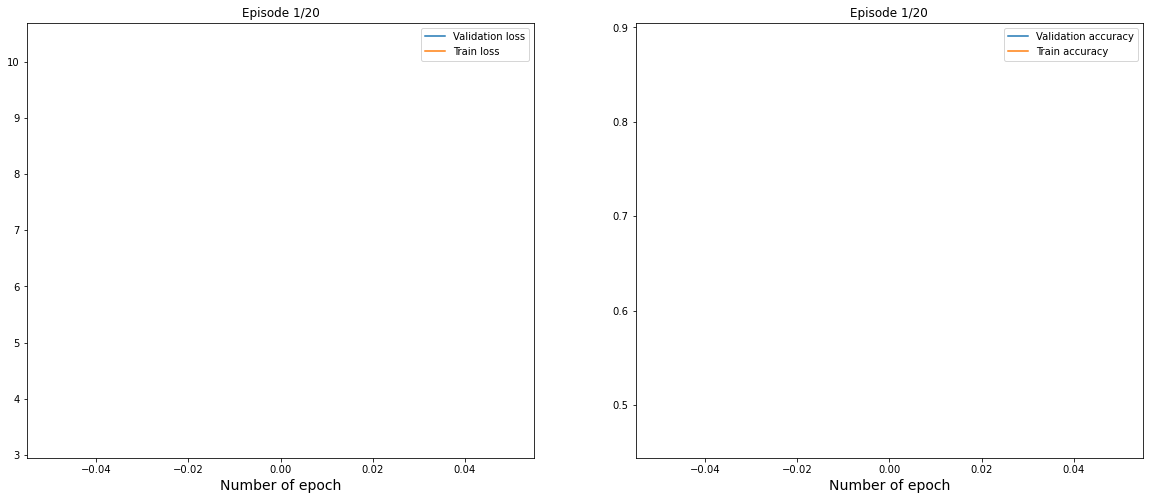

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
model = net.to(device)
criterion = torch.nn.BCELoss()  # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
optimizer = torch.optim.RMSprop(
    model.parameters(),
    weight_decay=1e-4,
    lr=1e-4,
    momentum=0.9
)

num_epochs = 20
train(train_loader, val_loader, model, criterion, num_epochs, device=device, dir_chechpoints ="aue")

# Проверка работы сети на входных картинках

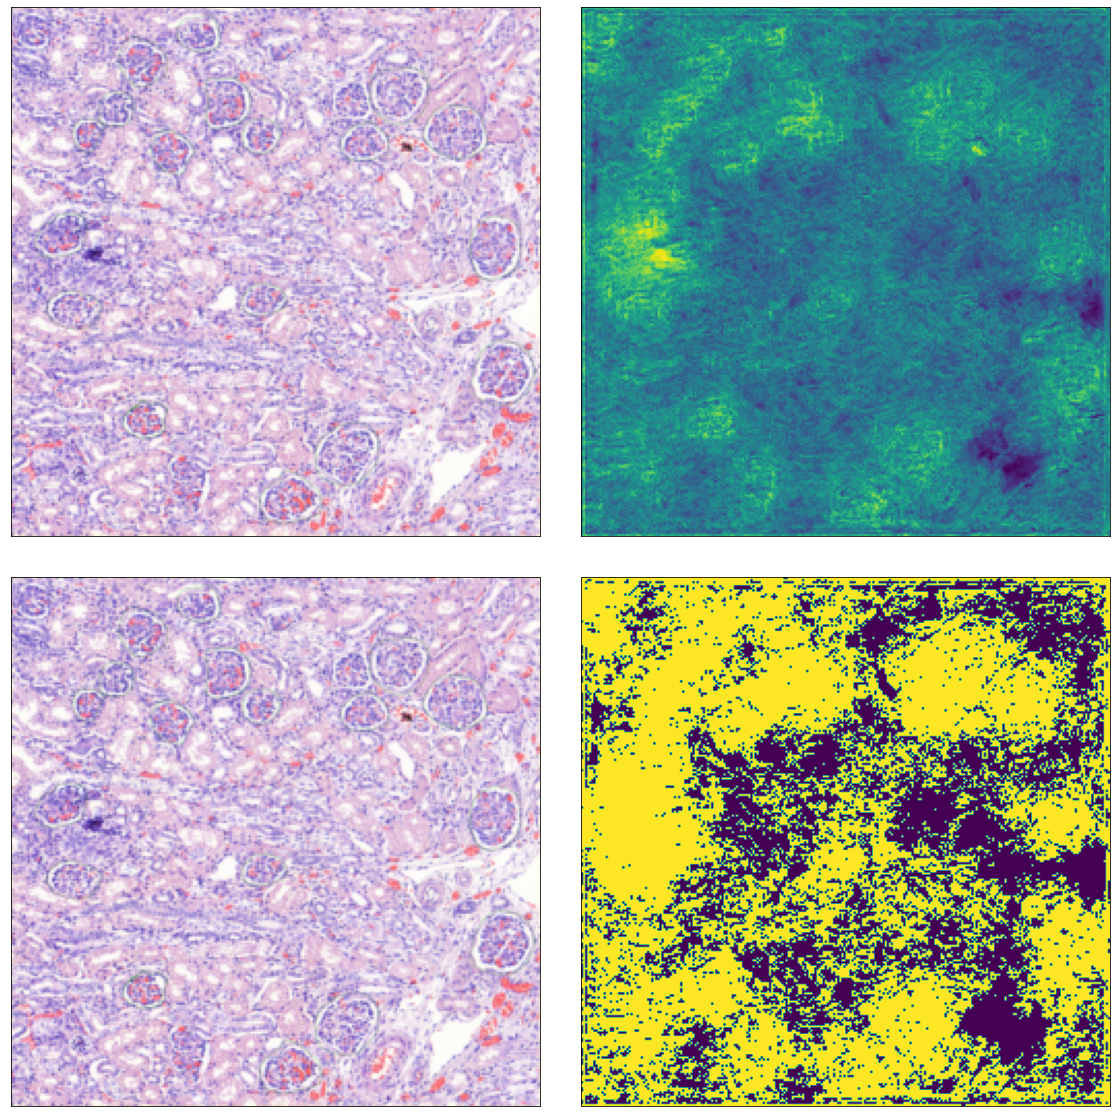

In [27]:
img_list = []
paths = ["./train/try.png"]
for path in paths:
    img = Image.open(path)
    img = transform(img)
    torch.round(mask[0])
    net.eval()
    mask = net(img.unsqueeze(dim=0).to(device))[0]
    img_list.append((img, mask))
    mask = torch.round(mask)
    img_list.append((img, mask))
im_show(img_list)